In [68]:
#The goal of this notebook is to demonstrate the image processing techniques used with dorsal closure data.
#The examples used are an excerpt of the data from Kiehart 4a

#Input: This script describes the image processing after downloading the video file, 
#converting to the appropriate format to open in imageJ, and running the corresponding ijm file 
#(in the github folder), and obtaining the output as a series of png images. 

#Steps taken:
#   1. Compress the image
#   2. Additionally sample to reduce points
#   3. Possibly add noise from Uniform([0, 1]^2) and output the results

In [69]:
#Inputs:
import glob
from IPython.display import Image
import imageio
import numpy as np

for im_path in glob.glob("Kiehart_4_Images/*.png"):
    img = Image(url=im_path, width=300, height=300)
    print("=====================================================")
    print("t = "+im_path[-7:-4], "Number points:", np.sum(imageio.imread(im_path))//255)
    display(img)
    #![title](img/picture.png)

t = 001 Number points: 47473


t = 010 Number points: 37907


t = 020 Number points: 35107


t = 030 Number points: 34413


t = 040 Number points: 35296


t = 050 Number points: 33892


t = 060 Number points: 28053


t = 070 Number points: 20393


t = 080 Number points: 15061


t = 090 Number points: 9423


# Step 1: Compression

In [70]:
#The function that does the compressing.
def squish(im, contract = 4):
    new_shape = (im.shape[0]//contract, im.shape[1]//contract)
    squashed = np.zeros(shape = new_shape, dtype = np.uint8)
    for i in range(new_shape[0]):
        for j in range(new_shape[1]):
            squashed[i][j] = 255*int(255*np.random.random()/2 < np.mean(im[contract*i:contract*i+contract, contract*j:contract*j+contract]))
    return squashed

#Loop through images, compress, and store/display the compressed images
for im_path in glob.glob("Kiehart_4_Images/*.png"):#Selects all the png's in the folder
     im = imageio.imread(im_path)
     compressed_im = squish(im)
     imageio.imwrite("Compressed_"+im_path, compressed_im)
     img = Image(url="Compressed_"+im_path, width=300, height=300)
     print("=====================================================")
     print("t = "+im_path[-7:-4], "Number points:", np.sum(compressed_im)//255)
     display(img)

t = 001 Number points: 4117


t = 010 Number points: 3391


t = 020 Number points: 3112


t = 030 Number points: 2980


t = 040 Number points: 3014


t = 050 Number points: 2741


t = 060 Number points: 2253


t = 070 Number points: 1641


t = 080 Number points: 1245


t = 090 Number points: 830


# Step 2: Sampling

In [71]:
#Convert images to dataframes, keep half the pixels, save to csv and display

import pandas as pd
from PIL import Image

def bin_img_sequence_to_df(import_filename, num_frames, source_folder="", print_preview = False):
    '''
    Binary Image -> DataFrames of Xs and Ys (white pixels) at each time
    Parameters:
    1. import_filename: images follow the naming format 
       [import_filename + frame number (indexed by 3 digits beginning at 001)]
    2. num_frames (currently max 999)
    3. source_folder: include path (include ending "/")
    4. print_preview
    Returns:
    tuple of dataFrames (x_vals, y_vals)
    Each column of DF corresponds to one image/frame/time, contains x (or y) coordinate of white points in that frame
    (equivalent to allx, ally in main code)
    '''
    x_vals = pd.DataFrame()
    y_vals = pd.DataFrame()
    
    for i in range(num_frames):
        num = i+1
        frame_no = str(num).zfill(3) #file ends in 3 digit number
        filepath = "{}{}{}.png".format(source_folder,import_filename,frame_no)

        #get image and turn into binary array
        try:
            img = Image.open(filepath).convert('1')
            np_img = np.array(img)
            np_img[np_img > 0] = 1
            np_img = np_img.astype(int)
            np_img = np.rot90(np_img, 3) #rotate to change origin from top left to bottom left

            #get coordinates of white points
            points = np.argwhere(np_img) #np array

            #add x and y coordinates of white points to new column of DataFrame
            x_col = points[:,0].tolist()
            new_xs = pd.DataFrame(x_col)
            x_vals = pd.concat([x_vals,new_xs], ignore_index=True, axis=1)

            y_col = points[:,1].tolist()
            new_ys = pd.DataFrame(y_col)
            y_vals = pd.concat([y_vals,new_ys], ignore_index=True, axis=1)
        except:
            pass
        
    if print_preview:
        print("Full CSVs of xs and ys")
        print("x_vals DataFrames:")
        print(x_vals)
        print("y_vals DataFrames:")
        print(y_vals)
        
    return (x_vals, y_vals)

import random

def all_points_to_sample(full_x_df, full_y_df, sample_max, sample_rate = None, print_preview = False):
    '''
    1. full_x_df: DataFrame of x-coordinates of points; a column per image/time with x-coordinates
       of points along the rows
    2. full_y_df: same as full_x_df, but for y-coordinates
    3. sampled_max
    4. print_preview
    Returns:
    tuple of DataFrames (sampled_x_vals, sampled_y_vals)
    
    '''
    sampled_x_vals = pd.DataFrame()
    sampled_y_vals = pd.DataFrame()
    
    total_sample_pts = 0
    
    #all pixels to sampling
    for i in range(full_x_df.shape[1]):
        #calculate sample size
        num_pts = full_x_df[i].count() #total num of white points
        
        if sample_rate is None:
            sample_size = min(sample_max, num_pts)
        else: 
            sample_size = int(num_pts*sample_rate)
        
        #sample points from full_x_df and full_y_df
        list_random = random.sample(range(num_pts),sample_size) #generate random indices to sampled points in DF
        sampled_xs = full_x_df.iloc[list_random,i].tolist()
        sampled_ys = full_y_df.iloc[list_random,i].tolist()
        
        #add x and y coordinates of sampled (white) points to new column of DataFrame
        new_xs = pd.DataFrame(sampled_xs)
        sampled_x_vals = pd.concat([sampled_x_vals,new_xs], ignore_index=True, axis=1)
        new_ys = pd.DataFrame(sampled_ys)
        sampled_y_vals = pd.concat([sampled_y_vals,new_ys], ignore_index=True, axis=1)
        
        total_sample_pts+=sample_size
    
    print(total_sample_pts)
    print(int(total_sample_pts/full_x_df.shape[1]))
    
    if print_preview:
        print("Sampled points (max " +str(sample_max)+"s)")
        print("x-coordinates of sampled points:")
        print(sampled_x_vals)
        print("y-coordinates of sampled points:")
        print(sampled_y_vals)
        
    return (sampled_x_vals, sampled_y_vals)

import matplotlib.pyplot as plt

def plot_csv(x_df, y_df, xy_dim, export = False, export_name = 'Img', export_directory = ''):
    '''
    Parameters:
    1. x_df: DataFrame of x-coordinates
    2. y_df: DataFrame of y-coordinates
    3. xy_dim: tuple of image dimensions
    4. export: T/F
    5. export_name: name of file to be exported
    6. export_directory: include path (include ending "/")
    Output:
    - Matplotlib
    - Saves image sequence to export_directory
    '''
    for time in range(x_df.shape[1]):
        i = time+1
        fig = plt.figure(figsize=(7, 5))
        ax = fig.gca()
        ax.set(xlim=(0,xy_dim[0]), ylim=(0, xy_dim[1]))
        plt.scatter(x_df[time],y_df[time], s=2)
        ax.set_aspect('equal')
        plt.title('img '+str(i))
        if export:
            filesavename = "{}{}_random_{}.png".format(export_directory,export_name, i)
            fig.savefig(filesavename, bbox_inches='tight')

In [72]:
all_x_df, all_y_df = bin_img_sequence_to_df('Kiehart4 Bin', 109, source_folder="Compressed_Kiehart_4_Images/", print_preview = True)

all_x_df, all_y_df = all_points_to_sample(all_x_df, all_y_df, 666, sample_rate=0.5, print_preview = True)

all_x_df.to_csv("example_sampled_compressed_dorsal_x_df.csv", header = None, index=None)
all_y_df.to_csv("example_sampled_compressed_dorsal_y_df.csv", header = None, index=None)



Full CSVs of xs and ys
x_vals DataFrames:
        0    1    2    3    4    5    6    7    8    9
0       0  2.0  1.0  0.0  0.0  0.0  1.0  2.0  1.0  2.0
1       2  3.0  2.0  0.0  0.0  0.0  1.0  3.0  2.0  3.0
2       2  4.0  2.0  0.0  1.0  2.0  2.0  5.0  2.0  4.0
3       3  4.0  3.0  0.0  2.0  2.0  3.0  5.0  2.0  5.0
4       3  5.0  3.0  0.0  2.0  2.0  3.0  7.0  2.0  9.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
4112  167  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4113  167  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4114  167  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4115  167  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
4116  167  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[4117 rows x 10 columns]
y_vals DataFrames:
       0      1     2     3     4     5      6      7     8      9
0     68  127.0  80.0  70.0  71.0  73.0   75.0  127.0  48.0  127.0
1     73  127.0  80.0  71.0  81.0  76.0   76.0  127.0  47.0  127.0
2     74   80.0  81.0  79.0  71.0  72.0  127.0    5.

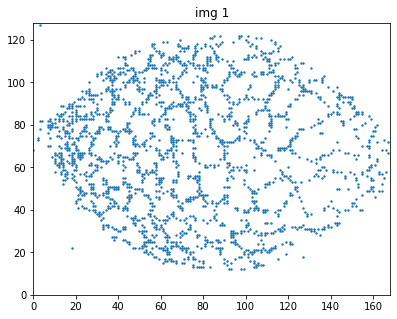

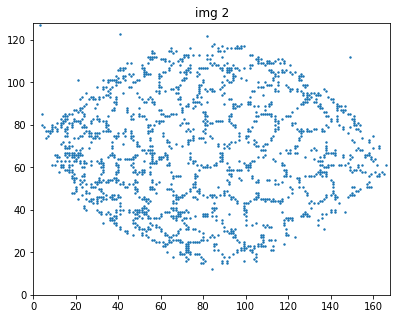

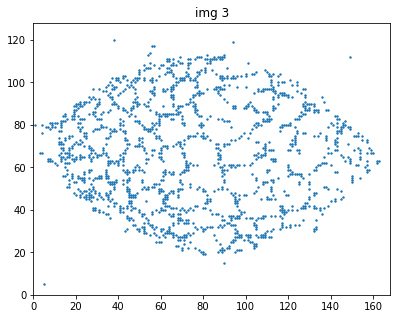

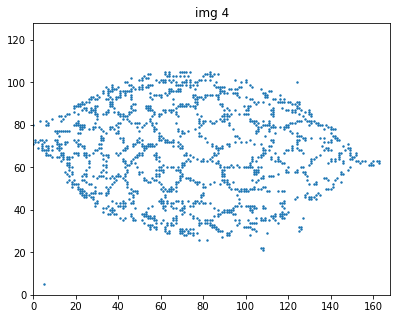

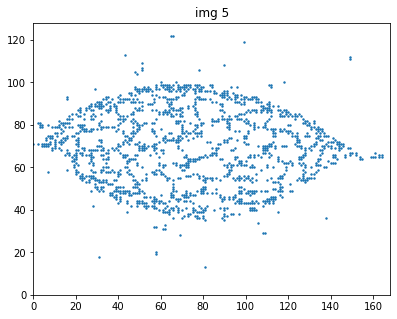

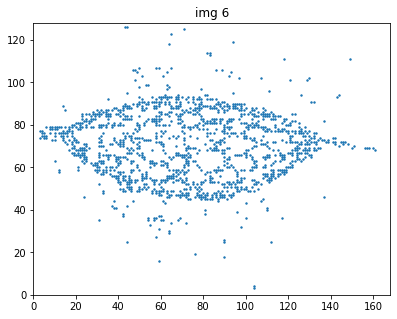

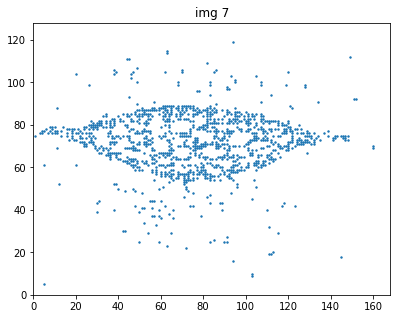

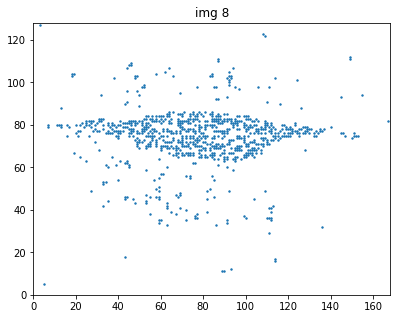

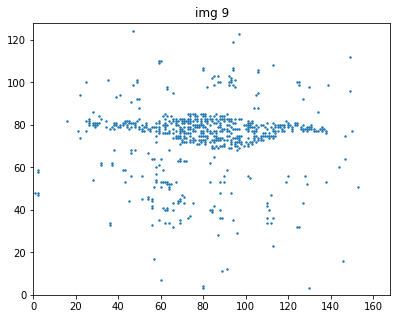

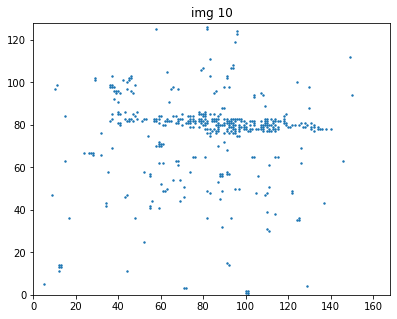

In [73]:
plot_csv(all_x_df, all_y_df, xy_dim=(168,128))

# Step 3: Add noise (optional) and output csv

In [74]:
def add_random_noise(x_df, y_df, print_preview = False):
    '''
    Adds unif(0,1) to every cell of DataFrames
    Parameters:
    1. x_df: DataFrame of x-coordinates
    2. y_df: DataFrame of y-coordinates
    Returns:
    Tuple of DataFrames (noisy_x_vals, noisy_y_vals)
    '''
    add_uniform_noise = lambda x: x+random.random()
    noisy_x_vals = x_df.applymap(add_uniform_noise)
    noisy_y_vals = y_df.applymap(add_uniform_noise)
    
    if print_preview:
        print(noisy_x_vals)
        print(noisy_y_vals)
    
    return (noisy_x_vals, noisy_y_vals)

#An option to add noise from Uniform([0, 1]^2). Comment below to remove
all_x_df, all_y_df = add_random_noise(all_x_df, all_y_df, print_preview = True)

all_x_df.to_csv("example_noisy_sampled_compressed_dorsal_x_df.csv", header = None, index=None)
all_y_df.to_csv("example_noisy_sampled_compressed_dorsal_y_df.csv", header = None, index=None)

               0           1          2           3           4          5  \
0      66.086352   38.719715  28.254897   67.208552  111.255042   5.342350   
1      57.646016  112.233905  97.570201   89.553758   19.369891  22.629343   
2      50.601706   28.929027  90.386482   70.281494   63.442911  80.142992   
3      54.684880   20.995843  65.132309  102.490161   58.104727  42.663575   
4      37.993819   72.053099  19.394418    7.862236  140.249071  62.651344   
...          ...         ...        ...         ...         ...        ...   
2053  153.419854         NaN        NaN         NaN         NaN        NaN   
2054   10.665371         NaN        NaN         NaN         NaN        NaN   
2055   78.930985         NaN        NaN         NaN         NaN        NaN   
2056  107.221768         NaN        NaN         NaN         NaN        NaN   
2057   33.509008         NaN        NaN         NaN         NaN        NaN   

              6          7           8           9  
0     59.7

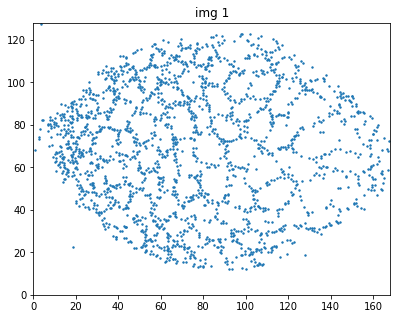

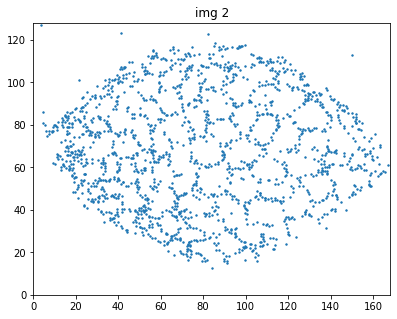

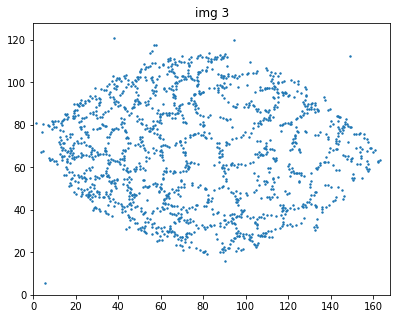

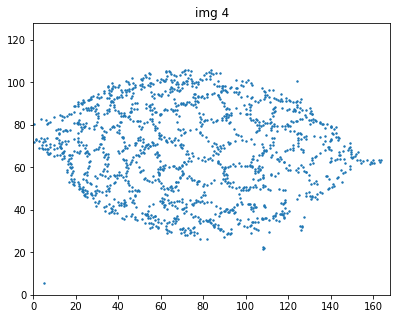

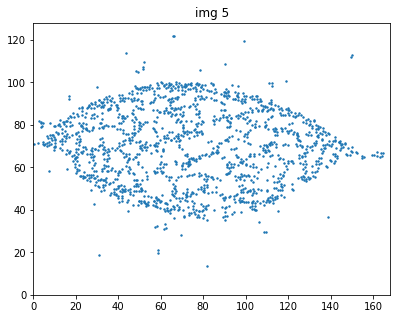

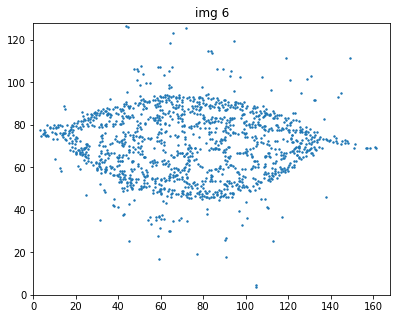

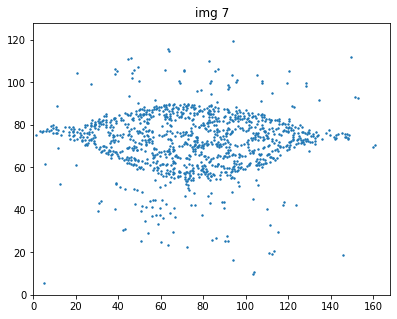

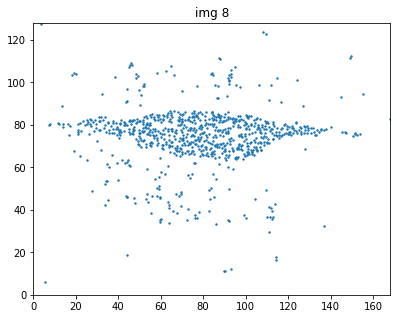

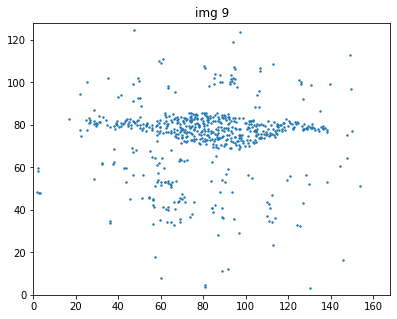

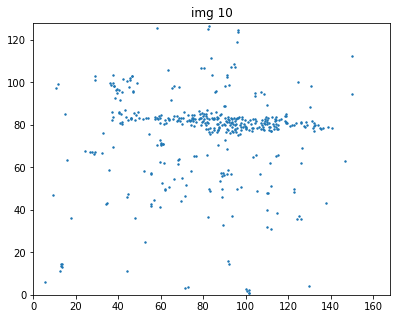

In [75]:
#If noise was added, see effects below
plot_csv(all_x_df, all_y_df, xy_dim=(168,128))